# Headspace Marketing Campaign

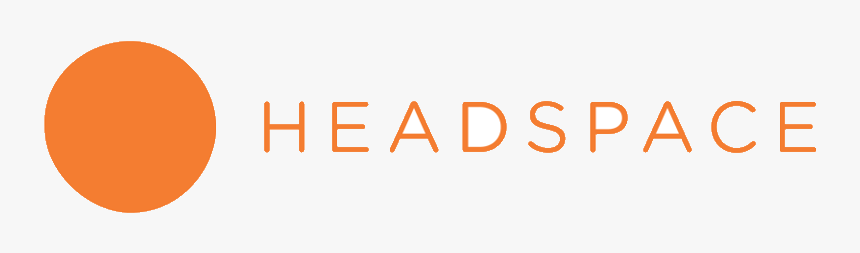

By: Seraj Khazei

# Overview

In this project, we are looking at facebook statuses, and the neurotic score based on the language used in the status update. The dataset includes more than 500,000 status updates. This dataset is well-suited for the business problem, as the goal is to identify neurotic individuals in order to send them ads for headspace.

For data preparation, I dropped non-relevant columns and assigned neurotic or not neurotic to each status update. Then, i used re to get rid of unimportant characters in the status update. After that, i tokenize the status to split each status into its respective words so that each word is a feature in the model. We also remove stopwords as they provide little to no sentiment value to the status. Lemmatization is performed to group words with the same meaning together as one word. TF-IDF is applied in order to assign each word in each tweet a numeric value based on its importance across all tweets. Finally, SMOTE is applied in order to eliminate the class imbalance observed in the target variable (sentiment). We used pandas to perform data filtering and visualization, nltk to perform text preprocessing, imblearn for oversampling and sklearn for TF-IDF.

For modeling, i utilized the sklearn's LogisticRegression, DecisionTree and RandomForestClassifier methods. I tuned our models using GridSearchCV also provided by sklearn.

Our final model has an f1 score of 84%, which means that it correctly identifies the sentiment of statues 84% of the time. I used a validation set and the test set f1 scores in order to validate our model performance.

# Business Understanding

Headspace among everyone in the world has noticed there has been a spike in depression and anxiety since the Pandemic has started. Headspace as being a mediation app understands they are capable of reducing the depression or anxiety rate at any scale, so in order to fufill the following task Headspace has created a special promotion for those who are already have mental illness or are of risk to mental illness. Although Headspace needs help to reach the individuals who meet the following requirement. This is where I come in to strategize a way to target the ads towards the following individuals and this notebook will be a demonstration for how the objective was tackled.

# Data Understanding

The dataset was acquired from https://aaai.org/Library/Workshops/ws13-01.php
which takes in various facebook statuses and scores the status on the big 5 peronality trait 

# Libaries

All the Libaries necessary for the notebook

In [196]:
import pandas as pd
import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import fbeta_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import f1_score, precision_score, plot_roc_curve
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [197]:
df = pd.read_csv('master_data.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

In [327]:
df

,status_update,Openness,Consciousness,Extraversion,Agreeablenes,Neuroticism
0,likes the sound of thunder.,4.4,3.25,2.65,3.15,3.00
1,is so sleepy it's not even funny that's she ca...,4.4,3.25,2.65,3.15,3.00
2,is sore and wants the knot of muscles at the b...,4.4,3.25,2.65,3.15,3.00
3,likes how the day sounds in this new song.,4.4,3.25,2.65,3.15,3.00
4,is home. <3,4.4,3.25,2.65,3.15,3.00
...,...,...,...,...,...,...
570149,can't wait until next sunday! <3,3.0,4.00,4.00,4.50,1.25
570150,babysitting :),3.0,4.00,4.00,4.50,1.25
570151,"Dear COD,\r\ni hate you. You consistantly stea...",3.0,4.00,4.00,4.50,1.25
570152,is in an amazing mood for some unknown reason XD,3.0,4.00,4.00,4.50,1.25


In [198]:
df['status_update'] = df['status_update'].astype(str)

The only relevant columns associated with my business problem will be `status_update` and `Neuroticism`

In [199]:
df_1 = df.drop(['Openness','Consciousness','Extraversion','Agreeablenes'], axis=1)

In [200]:
df_1['Neuroticism'].value_counts()

2.75    49841
3.00    46210
3.25    39221
2.25    38850
2.50    38214
        ...  
2.58       19
2.18       16
2.81       10
3.74        2
1.56        1
Name: Neuroticism, Length: 176, dtype: int64

In [236]:
# do more eda
#some visualizations, frequency count ,average: count of tweets, 

In order to have valid Neurotic scores a complete sentence is required per status update

In [201]:
df_1 = df_1[df_1['status_update'].str.len() >= 50].reset_index(drop=True)
#50 characters is the amount of characters for a average sentence

The function creates a target variable and prepares my dataset for the classification models ahead  
- (1): represents the user behind the status update has indications of `Neuroticism`
 
- (0): represents the user behind the status update does not have indications of `Neuroticism`

In [202]:
def number_map(x):
    if x > 3.50:
        return 1
    else:
        return 0

# A Neuroticism score higher than the median means being of risk to depression

In [203]:
df_1['Neuroticism'] = df_1['Neuroticism'].apply(number_map)

This bar plot protrays the class imbalance that consist in our dataset

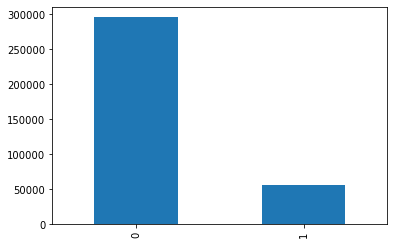

In [204]:
df_1['Neuroticism'].value_counts().plot(kind='bar');

# Text Preprocessing

In [205]:
#import re

In [206]:
df_1['status_update'] = df_1['status_update'].apply(lambda x:re.sub(r'[^\w\s]', '', x))  
## This lambda function will remove any punctations that consist in the status updates

df_1['status_update'] = df_1['status_update'].apply(lambda x:re.sub('[0-9]+', '',x))
##T his lambda function will remove any numbers that consist in the status updates

In [207]:
# from nltk.tokenize import TweetTokenizer
# from nltk.corpus import stopwords
# from nltk.stem.wordnet import WordNetLemmatizer

In the cell below the 
- "TweetTokenizer" will remove "@" symbols along with repetive characters that may be taking part in any status update.  
- "lemmatizer" will located words that have the same meaning and deduct them down to their root words in order to prevent the same word to be counted as seperate occasions
- Then a function is created with the the tokenizer and lemmatizer in order to apply the feature engingeering inside a TF-IDF vectorizer parameter

In [208]:
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True) 

lemmatizer = WordNetLemmatizer()

def lemmatize_and_tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [lemmatizer.lemmatize(token) for token in tokens]

# Modeling Preparation

### Train, Validation, and Test split

In [209]:
# from sklearn.model_selection import train_test_split

The `X` will represent the predictors

The `y` will represent the target variable

In [210]:
X = df_1['status_update']
y = df_1['Neuroticism']

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.25, random_state=42)
## TRAIN TEST SPLIT

In order to check for overfitting and underfitting a validation set will be made as well.

In [212]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.25, random_state=42)
## TRAIN Validation SPLIT

### TFIDF  Vectorization

Now that the dataset is cleaned, lemmatized and tokenized, it can now be converted into a vector format. In order to do so, TF-IDF vectorization will be used. This method is based on the idea that rare words are more valuable for prediction. The method utilizes two metrics:

- TF (term frequency) refers to the ratio of number of times a word appear in the document to the total number of words in the document.
- IDF (Inverse Document Frequency) refers to the logged ratio of number of documents to the number of documents including the word.

In [213]:
# from sklearn.feature_extraction.text import TfidfVectorizer

In [257]:
tfidf = TfidfVectorizer(max_features=500, stop_words='english', tokenizer=lemmatize_and_tokenize)

## my token pattern has been applied inside of "lemmatize_and_tokenize" function

In [258]:
## Fit the vectorizer on"status_update" and transform it
X_train_vectorized = tfidf.fit_transform(X_train)

In [216]:
## Same process on the validation set 
X_val_vectorized = tfidf.transform(X_val)

##Visually inspect the validation vectorized data
X_val_df = pd.DataFrame.sparse.from_spmatrix(X_val_vectorized, columns=tfidf.get_feature_names())

In order to deal with the imbalance displayed above we will be using `SMOTE` with a minority sampling strategy in order to not lose any data

In [217]:
# from imblearn.over_sampling import SMOTE
# from collections import Counter

The Counter package protrays that we resampled our class "1" to match the size of class "0"

In [218]:
smote = SMOTE(sampling_strategy='minority',random_state=42)

X_train_ros, y_train_ros = smote.fit_resample(X_train_vectorized, y_train)

print('Old shape of y:' + str(Counter(y_train)))
print('New shape of y:' + str(Counter(y_train_ros)))

Old shape of y:Counter({0: 166402, 1: 31759})
New shape of y:Counter({0: 166402, 1: 166402})


In [235]:
# Now we can visually inspect the X_train vectorized data after we resampled
X_train_df = pd.DataFrame.sparse.from_spmatrix(X_train_ros, columns=tfidf.get_feature_names())
print(X_train_df.columns.tolist())

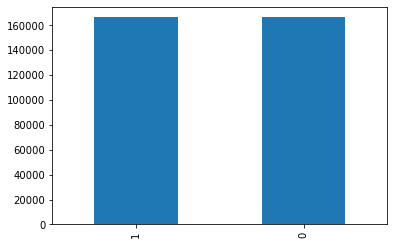

In [220]:
y_train_ros.value_counts().plot(kind='bar');

# First Simple Model

## Logistic Regression

Logistic Regression was chosen as the baseline model for the reason being that logistic regression provides simple and efficent method for binary classification problems, as well as the simpliest to explain in comparison to other models

## Metric:  F-beta score with beta=2

The reason for my metric of choosing can be traced back to the business understanding as my stakeholders priority is detecting the neurotic individuals as frequent as possible hence with beta = 2 the f1 score will put more weight on recall to allow for those individuals to be identified.

In [221]:
# from sklearn.metrics import fbeta_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import plot_confusion_matrix, plot_roc_curve

In [325]:
logreg = LogisticRegression()

logreg.fit(X_train_df, y_train_ros)

y_train_pred = logreg.predict(X_train_df)
y_val_pred = logreg.predict(X_val_df)

In [326]:
training_f1_score = fbeta_score(y_train_ros, y_train_pred, average='micro', beta=2)
validation_f1_score = fbeta_score(y_val, y_val_pred, average='micro', beta=2)

print(f'training f1 score:{training_f1_score}')
print(f'validation f1 score:{validation_f1_score}')

training f1 score:0.6140701433876997
validation f1 score:0.5774820601326187


In [290]:
# validation_recall = recall_score(y_val, y_val_pred, average='weighted')
# validation_f1 = f1_score(y_val, y_val_pred, average='weighted')
# validation_precision = precision_score(y_val, y_val_pred, average='weighted')

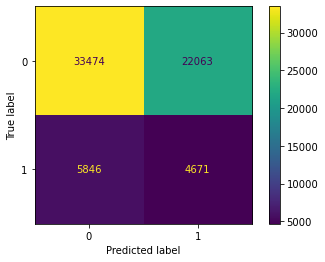

In [291]:
# print(f'validation: recall:{validation_recall}, precision:{validation_precision}, f1:{validation_f1}')
plot_confusion_matrix(logreg,X_val_df,y_val);

In [ ]:
# recall based on business problem or f1


In [237]:
#plot_roc_curve(logreg,X_val_df,y_val)

# Model Iterations

Now model iterations will take place with hyperparameter tuning through gridsearches

## Model Iterations #1  

### Logistic Regression

In [293]:
# from sklearn.metrics import make_scorer
# from imblearn.pipeline import Pipeline as imbpipeline
# from sklearn.model_selection import GridSearchCV

In [295]:
log_pipeline = imbpipeline(steps=[
          ('vect', TfidfVectorizer(stop_words='english', tokenizer=lemmatize_and_tokenize,
                                   strip_accents='ascii',ngram_range =(1,2))),
           ('smote', SMOTE(sampling_strategy='minority',random_state=42)),
           ('logreg', LogisticRegression()) 
])
           

log_parameters = {
 'vect__max_df' : [1,0.8],
 'vect__min_df' : [1],  
 'logreg__penalty': ['l2','l1'],
 'logreg__solver': ['newton-cg', 'lbfgs']   
}

gs_logreg = GridSearchCV(log_pipeline, log_parameters, scoring= make_scorer(fbeta_score, beta=2))
gs_logreg.fit(X_train, y_train)
gs_logreg.best_params_

{'logreg__penalty': 'l2',
 'logreg__solver': 'newton-cg',
 'vect__max_df': 1,
 'vect__min_df': 1}

In [322]:
y_train_pred = gs_logreg.predict(X_train)
y_val_pred = gs_logreg.predict(X_val)

training_f1_score = fbeta_score(y_train, y_train_pred, average='micro', beta=2)
validation_f1_score = fbeta_score(y_val,y_val_pred, average='micro', beta=2)

print(f'training f1 score:{training_f1_score}')
print(f'validation f1 score:{validation_f1_score}')

training f1 score:0.9464677711557774
validation f1 score:0.8429769582462834


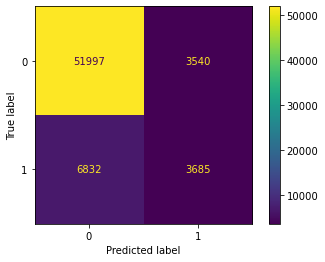

In [297]:
plot_confusion_matrix(gs_logreg,X_val,y_val);

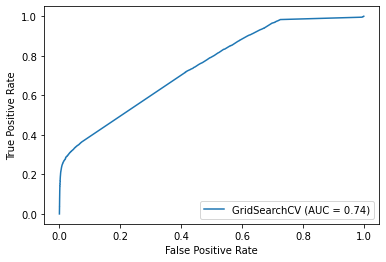

In [298]:
plot_roc_curve(gs_logreg,X_val,y_val)

## Model Iterations #2

### Decision Tree

In [299]:
# from sklearn.tree import DecisionTreeClassifier

In [300]:
dtc_pipeline = imbpipeline(steps=[
           ('vect', TfidfVectorizer(stop_words='english', tokenizer=lemmatize_and_tokenize, 
                                    strip_accents='ascii',ngram_range =(1,2))),
           ('smote', SMOTE(sampling_strategy='minority',random_state=42)),
           ('dtc', DecisionTreeClassifier()) 
])
           

dtc_parameters = {
 'vect__max_df' : [1,0.8],
 'vect__min_df' : [1],
 'dtc__criterion': ['gini', 'entropy'],
 'dtc__max_depth': [50,100]      
}

gs_dtc = GridSearchCV(dtc_pipeline, dtc_parameters, scoring= make_scorer(fbeta_score, beta=2))
gs_dtc.fit(X_train, y_train)
gs_dtc.best_params_

{'dtc__criterion': 'gini',
 'dtc__max_depth': 100,
 'vect__max_df': 1,
 'vect__min_df': 1}

In [321]:
y_train_pred = gs_dtc.predict(X_train)
y_val_pred = gs_dtc.predict(X_val)

training_f1_score = fbeta_score(y_train, y_train_pred, average='micro', beta=2)
validation_f1_score = fbeta_score(y_val,y_val_pred, average='micro', beta=2)

print(f'training f1 score:{training_f1_score}')
print(f'validation f1 score:{validation_f1_score}')

training f1 score:0.8402359697417756
validation f1 score:0.8408574802434372


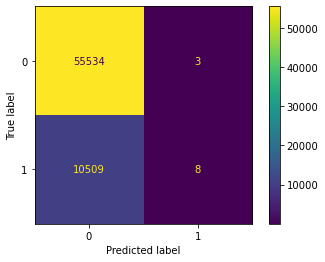

In [302]:
plot_confusion_matrix(gs_dtc,X_val,y_val);

In [303]:
# focus on "f1" sklearn f1 beta score custom metric 

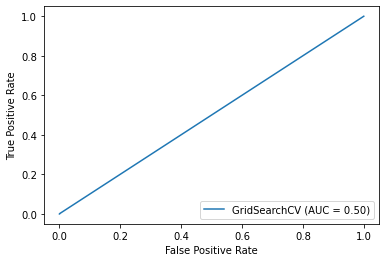

In [304]:
plot_roc_curve(gs_dtc,X_val,y_val)

## Model Iterations #3

### Random Forest

In [305]:
# from sklearn.ensemble import RandomForestClassifier

In [306]:
rfc_pipeline = imbpipeline(steps=[
           ('vect', TfidfVectorizer(stop_words='english', tokenizer=lemmatize_and_tokenize, 
                                    strip_accents='ascii',ngram_range =(1,2))),
           ('smote', SMOTE(sampling_strategy='minority',random_state=42)),
           ('rfc', RandomForestClassifier()) 
])
           

rfc_parameters = {
 'vect__max_df' : [1],
 'vect__min_df' : [1],
 'rfc__criterion': ['gini', 'entropy'],
 'rfc__max_depth': [50,100]        
}

gs_rfc = GridSearchCV(rfc_pipeline, rfc_parameters, scoring= make_scorer(fbeta_score, beta=2))
gs_rfc.fit(X_train, y_train)
gs_rfc.best_params_

{'rfc__criterion': 'gini',
 'rfc__max_depth': 100,
 'vect__max_df': 1,
 'vect__min_df': 1}

In [320]:
y_train_pred = gs_rfc.predict(X_train)
y_val_pred = gs_rfc.predict(X_val)

training_f1_score = fbeta_score(y_train, y_train_pred, average='micro', beta=2)
validation_f1_score = fbeta_score(y_val,y_val_pred, average='micro', beta=2)

print(f'training f1 score:{training_f1_score}')
print(f'validation f1 score:{validation_f1_score}')

training f1 score:0.8584837581562467
validation f1 score:0.8449904623489872


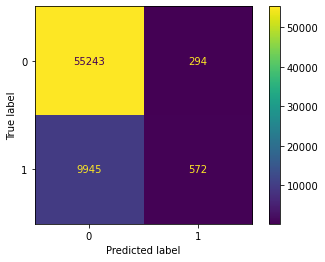

In [308]:
plot_confusion_matrix(gs_rfc,X_val,y_val);

# Final Model

### Logistic regression with penalty ='l2' and solver = 'newton-cg'

In [227]:
log_pipeline_t = imbpipeline(steps=[
           ('vect', TfidfVectorizer(max_df=1, min_df=1, stop_words='english', tokenizer=lemmatize_and_tokenize, 
                                    strip_accents='ascii',ngram_range =(1,2))),
           ('smote', SMOTE(sampling_strategy='minority',random_state=42)),
           ('logreg', LogisticRegression(penalty ='l2',solver = 'newton-cg'))])

In [228]:
log_pipeline_t.fit(X_train,y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(max_df=1, ngram_range=(1, 2),
                                 stop_words='english', strip_accents='ascii',
                                 tokenizer=<function lemmatize_and_tokenize at 0x7fd5135ed160>)),
                ('smote', SMOTE(random_state=42, sampling_strategy='minority')),
                ('logreg', LogisticRegression(solver='newton-cg'))])

In [229]:
y_test_preds = log_pipeline_t.predict(X_test)

In [319]:
test_f1_score = fbeta_score(y_test,y_test_preds, average='micro', beta=2)
print(f'Test_f1_score:{test_f1_score}')

Test_f1_score:0.8430715777999819


In [310]:
# test_recall = recall_score(y_test, y_test_preds, average='weighted')
# test_precision = precision_score(y_test, y_test_preds, average='weighted')
# test_f1 = f1_score(y_test, y_test_preds, average='weighted')

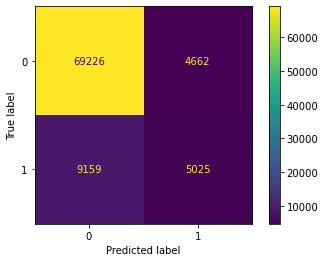

In [311]:
plot_confusion_matrix(log_pipeline_t, X_test,y_test);

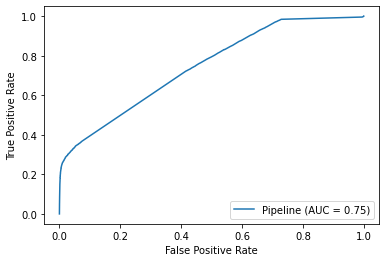

In [312]:
plot_roc_curve(log_pipeline_t,X_test,y_test)

In [313]:
#Finding feature importance
log_model_cv_coefs = pd.Series(index=log_pipeline_t.named_steps['vect'].get_feature_names(), 
                               data=log_pipeline_t['logreg'].coef_[0]).sort_values(ascending=True)

log_model_cv_coefs = pd.DataFrame(log_model_cv_coefs)

log_model_odds_ratio=log_model_cv_coefs
log_model_odds_ratio.head(450)

,0
zzzxpsleep,-0.385524
glee sleep,-0.385524
stupidity procrastination,-0.385524
stupidity dont,-0.385524
stupid week,-0.385524
...,...
story look,-0.385524
going gain,-0.385524
going gaga,-0.385524
going fuuun,-0.385524


# Conclusion

The goal of this project was to come up with a method to identify individuals who show indications of Neuroticism in order to send them promotional ads to ulitmatley try to reduce the recent spike of depression and or anxiety. This was done by creating multiple classification models and identified the best one as a logistic regression model with an f1 of 84%. This model will allow our stakeholder to identify the neurotic users and target their ads accordingly.

# Future Research

Majority of the status updates were non-neurotic, more neurotic status updates should gathered in order to eliminate class imbalance without artificial methods. As well as gather data from various other media platforms to be able to reach a wider audience.